# Определение токсичных комментариев с помощью нейронной сети

1. Ссылка на наше соревнование [HA: toxic comment classification](https://www.kaggle.com/c/ha-toxic-comment-classification?rvi=1).

2. Для создания векторов слов применим эмбеддинг [BPE](https://nlp.h-its.org/bpemb/),
используя предобученную модель.

3. Для решения задачи бинарной классификации (toxic / nontoxic) применим фреймворк [Flair](https://github.com/zalandoresearch/flair).
Flair - небольшой активно развивающийся фреймворк для некоторых задач NLP
(классификация текстов, NER), работающий поверх Pytorch.
С его помощью можно буквально за несколько строк собрать NLP-модель,
используя самые передовые технологии обработки естественного языка.


In [45]:
# Подключаем диск Google Drive, на котором будем хранить данные
# from google.colab import drive
# drive.mount('/content/drive')

In [46]:
# !pip install flair

In [1]:
import os
import pandas as pd
import numpy as np
import re

from flair.data import Corpus
from flair.datasets import ClassificationCorpus
from flair.embeddings import BytePairEmbeddings
from flair.embeddings import DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.visual.training_curves import Plotter

from flair.data import Sentence

import matplotlib.pyplot as plt
from matplotlib import rcParams

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

plt.figure(figsize=(12, 6), dpi=100)
plt.style.use('bmh')

<Figure size 1200x600 with 0 Axes>

## 1. Анализ и подготовка датасета

Скачать датасет можно по этим ссылкам:
* Ссылка на страницу датасета: [Russian Language Toxic Comments](https://www.kaggle.com/blackmoon/russian-language-toxic-comments).
* Ссылка на файл: [russian-language-toxic-comments.zip](https://www.kaggle.com/blackmoon/russian-language-toxic-comments/downloads/russian-language-toxic-comments.zip)

Скачать датасет можно так:



```
wget -O save/path/file.zip https://www.kaggle.com/blackmoon/russian-language-toxic-comments/downloads/russian-language-toxic-comments.zip
```

Потом разархивировать:


```
unzip file.zip
```



In [2]:
df = pd.read_csv('simple_train.csv')

In [3]:
df.head(10)

# TODO: skip first column w/ id

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0
9,00040093b2687caa,alignment on this subject and which are contra...,0


In [4]:
# toxic у нас категориальный признак, а не количественный,
# поэтому преобразуем его
# df.toxic = df.toxic.apply(int)
# df.head(10)




<AxesSubplot:>

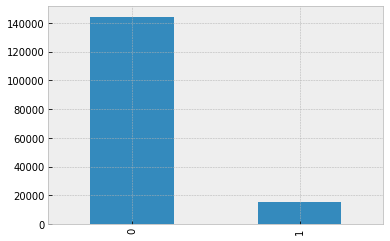

In [5]:
# Посмотрим на распределение нашего датасета
df.toxic.value_counts().plot.bar()

In [6]:
# Как видно из графика, наш датасет несбалансирован,
# что может отрицательно повлиять на качество
# обучения модели
df.toxic.value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [7]:
# Удалим часть данных с меткой 0, т.е. нетоксичных комментариев.
# Это хоть и уменьшит выборку, но сделает её более сбалансированной.
df = pd.concat([df[df.toxic == 0].sample(15294), df[df.toxic == 1]], ignore_index = True)

<AxesSubplot:>

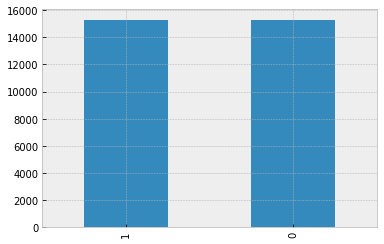

In [8]:
df.toxic.value_counts().plot.bar()

In [14]:
# посмотрим на облако слов
df_toxic_comment = df.comment_text[df.toxic==1]
df_toxic_comment.head()

15294         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
15295    Hey... what is it..\n@ | talk .\nWhat is it......
15296    Bye! \n\nDon't look, come or think of comming ...
15297    You are gay or antisemmitian? \n\nArchangel WH...
15298             FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
Name: comment_text, dtype: object

In [17]:
# toxic_text = " ".join(txt for txt in df_toxic_comment.text)
toxic_text = " ".join(txt for txt in df_toxic_comment)

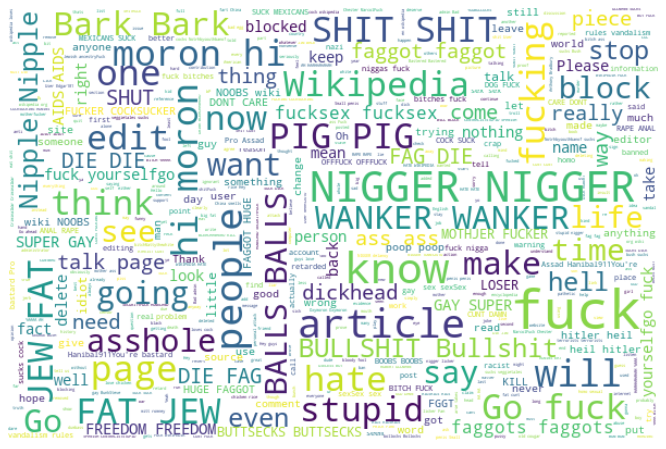

In [18]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=500,
                      width = 600, height = 400,
                      background_color="white").generate(toxic_text)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [13]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=500,
                      width = 600, height = 400,
                      background_color="white").generate(df_toxic_comment)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


TypeError: expected string or bytes-like object

In [ ]:
Подготовим текст:
1. Удалим переносы строк.
2. Оставим только буквенный текст (удалим знаки препинания, цифры и иные символы).
3. Приведём текст к нижнему регистру.

In [ ]:
Подготовим текст:
1. Удалим переносы строк.
2. Оставим только буквенный текст (удалим знаки препинания, цифры и иные символы).
3. Приведём текст к нижнему регистру.

Подготовим текст:
1. Удалим переносы строк.
2. Оставим только буквенный текст (удалим знаки препинания, цифры и иные символы).
3. Приведём текст к нижнему регистру.

In [25]:
# все применяем к столбцу comment_text

df.comment_text = df.comment_text.str.replace('\n', ' ', regex=False)
# df.comment = df.comment.str.replace('ё', 'е', regex=False)
df.comment_text = df.comment_text.str.replace('[^a-zA-Zа-яА-Я]+', ' ')
df.comment_text = df.comment_text.str.lower()

Чтобы в ходе подбора оптимальной модели не производить манипуляции с датасетом, сохраним наши подготовленные данные.

Сохраним предподготовленный датасет в файлы формата [fasttext](https://fasttext.cc/).
Это текстовый файл, в котором сохранены предобработанные тексты с меткой класса -
для различных классификаций текстов.

Первым параметром идёт метка, начинающаяся со служебного слова `__label__`.

Например, так: `__label__mark` или так: `__label__0`.

Затем через пробел идёт сам предобработанный текст.
Каждый элемент датасета начинается с новой строки.

Для этого преобразуем признак `toxic`. И поменяем колонки местами.

In [26]:
df.toxic = '__label__' + df.toxic.apply(str)
df = df.reindex(columns=['toxic', 'comment_text'])
df.sample(5)

,toxic,comment_text
16046,__label__1,excuse me whoever the fuck you are spui says o...
2224,__label__0,its not incorrect information i am from headqu...
1554,__label__0,this message is regarding the page pgufs thank...
17941,__label__1,hey dan fredinburg is indeed a notable person ...
14349,__label__0,i have contacted a few editors who have partic...


Разбиваем предобработанный датасет на три выборки:
* обучающую
* валидационную
* тестовую

In [27]:
# https://stackoverflow.com/a/38251063
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [28]:
train, validate, test = train_validate_test_split(df, train_percent=.7, validate_percent=.2, seed=700)
train.shape[0], validate.shape[0], test.shape[0]

(21411, 6117, 3060)

In [29]:
print('done')

done


In [30]:
# print(os.getcwd())
# data_path = str(os.getcwd())+'/docs/'
# print(data_path)

In [3]:
if not os.path.exists('files'):
    os.makedirs('files')

In [31]:
file_path = 'files/'
train.to_csv(file_path+'toxic.train.fasttext',
             sep=' ',
             index=False,
             header=None)
validate.to_csv(file_path+'toxic.validate.fasttext',
                sep=' ',
                index=False,
                header=None)
test.to_csv(file_path+'toxic.test.fasttext',
            sep=' ',
            index=False,
            header=None)

In [33]:
print('done')

done


In [34]:
# 3. Создание и тренировка модели

Мы не будем создавать собственный словарь и собственные вектора слов, а будем использовать уже готовые модели.

Для [эмбеддинга](https://www.nkj.ru/open/36052/) мы возьмём модель **BPE** - [Byte Pair Embeddings](https://nlp.h-its.org/bpemb/).

Во-первых, если мы будем использовать свой словарь - словарь, основанный на словах из нашего датасета,
то всегда есть возможность, что в процессе использования модели ей встретится незнакомое слово.

Во-вторых, уже существующие полнословные словари слишком большие.

В-третьих, с помощью модели BPE мы будем учитывать возможные опечатки в тексте
и жаргонную лексику, а это очень распространённое явление в пользовательских комментариях в соцсетях. Такая модель, как, например, FastText тоже умеет учитывать не встречающиеся в её словаре слова, но она слишком большая - всё это (в частности для русского языка) из-за того, что слова в словаре были некачественно предобработаны.


SyntaxError: invalid syntax (<ipython-input-34-c6b5f63d1c02>, line 3)

# Загружаем подготовленный датасет
# Для более быстрой обработки информации можно весь датасет поместить в 
# оперативную память. Для этого выставляем флаг: in_memory=True
# data_folder = '/model/'

corpus: Corpus = ClassificationCorpus(
    # data_path, # папка, в воторой расположены файлы датасета
    train_file='toxic.train.fasttext', # данные для обучения модели
    dev_file='toxic.validate.fasttext', # данные для валидации модели
    test_file='toxic.test.fasttext', # тестовые данные, не участвующие в ходе обучения
    in_memory=True
    )

In [35]:
# Загружаем подготовленный датасет
# Для более быстрой обработки информации можно весь датасет поместить в 
# оперативную память. Для этого выставляем флаг: in_memory=True
# data_folder = '/model/'

corpus: Corpus = ClassificationCorpus(
    data_path, # папка, в воторой расположены файлы датасета
    train_file='toxic.train.fasttext', # данные для обучения модели
    dev_file='toxic.validate.fasttext', # данные для валидации модели
    test_file='toxic.test.fasttext' # тестовые данные, не участвующие в ходе обучения
    # in_memory=True
    )

NameError: name 'corpus' is not defined

In [42]:
# Проверим загруженные данные
print(len(corpus.train), len(corpus.dev), len(corpus.test), sep=', ')

NameError: name 'corpus' is not defined

In [38]:
# Наши метки
# 0 - нетоксичный комментарий, 1 - токсичный
label_dict = corpus.make_label_dictionary()

2019-08-26 06:09:48,231 {'0', '1'}


Как говорилось выше, мы используем BPE в качестве эмбеддинга. Параметры же нашей нейронки таковы:

Мы используем 2 слоя двунаправленной сети [GRU](https://ru.wikipedia.org/wiki/Управляемый_рекуррентный_блок) со скрытым слоем, равным 124. Сеть GRU - это вариации рекуррентной нейронной сети LSTM. Реккурентные нейронные сети зарекомендовали себя, как хороший обработчик последовательностей. Тексты - это как раз последовательности.

Двунаправленность используется в связи с тем, что в предложении русского языка нет чёткой последовательности слов (*кот ушёл* и *ушёл кот*), поэтому наша сеть будет проходить предложение как с начала, так и с конца, чтобы лучше понять его.

In [48]:
# Инициализируем эмбеддинг на основе BPE
bp_embedding = BytePairEmbeddings('ru')

# Далее задаём параметры нейронной сети.
document_emb = DocumentRNNEmbeddings(
    [bp_embedding],
    hidden_size=128,
    reproject_words=True, # трансформируем входящий вектор
    reproject_words_dimension=256,
    rnn_layers=2,
    bidirectional=True,
    dropout=0.2,
    word_dropout=0.2,
    rnn_type='GRU')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Инициализируем текстовый классификатор
classifier = TextClassifier(document_emb, label_dictionary=label_dict)
# По умолчанию в качестве оптимизатора используется SGD.
# Мы будем использовать его, поэтому не указываем явно тип оптимизатора:
trainer = ModelTrainer(classifier, corpus)

# Если же нужно использовать какой-то иной алгоритм, его нужно указать:
#
# from torch.optim.adam import Adam
# trainer = ModelTrainer(classifier, corpus, optimizer=Adam)

# По умолчанию данный фреймворк использует GPU. Если GPU нет, фреймворк сам 
# выбирает CPU.
# Если для обучения используется CPU, можно указать количество процессоров
# trainer.num_workers = 15
#
# Что используется на данный момент, можно узнать, выполнив слудующий код:
# import flair
# print(flair.device)

In [50]:
# Начинаем тренировку
# Можно указывать сколько угодно много эпох, а потом, когда модель будет 
# достаточно обучена, остановить выполнение кода. Фреймворк поймёт, что
# надо прекратить обучение,- остановится, пересчитает все веса. Но даже если
# не останавливать принудительно модель, то фреймворк увидит, когда уже нет
# возможности делать модель лучше, и тоже остановит обучение.
# и сохранит наилучший результат в файл best_model.pt
#
# не обязательно делать слишком маленький learning_rate.
# При необходимости фреймворк сам его уменьшит.
trainer.train(
    '/content/drive/My Drive/colab_data/toxic/model',
    learning_rate=0.1,  
    mini_batch_size=64,
    anneal_factor=0.5,
    patience=5,
    max_epochs=5,
    monitor_train=True)

2019-08-26 08:41:50,573 ----------------------------------------------------------------------------------------------------
2019-08-26 08:41:50,575 Evaluation method: MICRO_F1_SCORE
2019-08-26 08:41:50,847 ----------------------------------------------------------------------------------------------------
2019-08-26 08:41:51,484 epoch 1 - iter 0/106 - loss 0.42727622
2019-08-26 08:41:54,646 epoch 1 - iter 10/106 - loss 0.40622200
2019-08-26 08:41:56,907 epoch 1 - iter 20/106 - loss 0.39005942
2019-08-26 08:42:00,063 epoch 1 - iter 30/106 - loss 0.39126687
2019-08-26 08:42:03,308 epoch 1 - iter 40/106 - loss 0.40461460
2019-08-26 08:42:06,018 epoch 1 - iter 50/106 - loss 0.39512310
2019-08-26 08:42:08,960 epoch 1 - iter 60/106 - loss 0.39174748
2019-08-26 08:42:11,404 epoch 1 - iter 70/106 - loss 0.39293055
2019-08-26 08:42:13,760 epoch 1 - iter 80/106 - loss 0.38896372
2019-08-26 08:42:16,448 epoch 1 - iter 90/106 - loss 0.39090168
2019-08-26 08:42:19,135 epoch 1 - iter 100/106 - loss

{'dev_loss_history': [tensor(0.4408, device='cuda:0'),
  tensor(0.3687, device='cuda:0'),
  tensor(0.3632, device='cuda:0'),
  tensor(0.3745, device='cuda:0'),
  tensor(0.3598, device='cuda:0')],
 'dev_score_history': [0.8031, 0.8451, 0.8456, 0.8482, 0.8554],
 'test_score': 0.8602,
 'train_loss_history': [tensor(0.3965, device='cuda:0'),
  tensor(0.3334, device='cuda:0'),
  tensor(0.3241, device='cuda:0'),
  tensor(0.3256, device='cuda:0'),
  tensor(0.3156, device='cuda:0')]}

## 4. Использование модели.

Я остановил тренировку после 5-й эпохи. Результаты лучшей модели таковы:

* Accuracy: 75%
* F1: 86%

Естественно, можно попытаться улучшить качество модели, изменяя параметры и гиперпараметры, а также увеличив количество эпох тренировки.

На заключительном этапе посмотрим: 
* как обучалась модель;
* как загрузить лучшую модель;
* как использовать сохранённую модель.

In [0]:
# Построим график обучения модели
plotter = Plotter()
plotter.plot_training_curves('/content/drive/My Drive/colab_data/toxic/model/loss.tsv')
# Сохранённый график обучения модели ищите в этой же папке.
# Название файла: training.png

In [52]:
# Загружаем модель для использования
model = TextClassifier.load('/content/drive/My Drive/colab_data/toxic/model/best-model.pt')

2019-08-26 08:54:28,926 loading file /content/drive/My Drive/colab_data/toxic/model/best-model.pt


In [53]:
# Сколько параметров у нашей модели
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'В ходе тренировки модели было использовано {count_parameters(model):,} параметров.')

В ходе тренировки модели было использовано 224,514 параметров.


Для того, чтобы получить результат не для целого датасета, а для одного предложения, в фреймворке Flair имеется `Sentence`.

In [0]:
# Предобработка единичного комментария
# Те же самые операции, что мы производили над датасетом,
# только теперь для единичного комментария.
def preprocess_text(text):
  text = text.replace('\n', ' ')
  text = text.replace('ё', 'е')
  text = re.sub('[^a-zA-Zа-яА-Я]+', ' ', text).lower()
  return text.strip()

In [63]:
# создаём экземпляр Sentence и передаём его нашей модели
t = 'Да вы все ёбаные пидарасы!'

sentence = Sentence(preprocess_text(t))
model.predict(sentence)

print(sentence.labels)

[1 (0.8408752679824829)]


**Великолепно!**

Модель нам верно указала, что данный комментарий является токсичным (метка 1).

Вероятность токсичности комментария: 84%.